# Atlas Segmentation - Medical Image Segmentation and Applications (MISA)

This notebook contains all necessary code to segment brain tissues (WM, GM, CSF) using probabilistic atas based approach.

## 1. Imports

In [1]:
import os
import subprocess
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from EM import NiftiManager, Evaluate, ElastixTransformix, FileManager, BrainAtlasManager

pp = pprint.PrettyPrinter(indent=4)

## 2. Helper functions

In [2]:
NM    = NiftiManager()
EVAL  = Evaluate()
ET    = ElastixTransformix()
FM    = FileManager()
BM    = BrainAtlasManager()

In [3]:
def skull_stripping(image, label):
    '''Performs only skull stripping and returns the volume with the label tissues only.
    
    Args:
        image ('np.array'):
            An intensity volume for the brain in the form of a numpy array.
        
        label ('np.array'):
            The labels volume associated to the intensity volume passed as an image.

    Returns:
        The skull stripped volume in the same shape of the passed intensity volume. The output will still contain
        background labelled as 0 as a result of the multiplication. The output volume is a numpy array.
    '''
    # convert the labels to binary form, all tissues to 1, else is 0
    labels_mask   = np.where(label == 0, 0, 1)

    # multiply the image to get only the tissues
    return np.multiply(image, labels_mask)


In [4]:
print(ET.excute_cmd('elastix --version'))

elastix version: 4.200



In [5]:
test_path = 'test-set/testing-images'
test_labels_path = 'test-set/testing-labels'
test_masks_path = 'test-set/testing-mask'

test_volumes = sorted(glob(os.path.join(test_path, "*.nii.gz"), recursive=True))
test_labels = sorted(glob(os.path.join(test_labels_path, "*.nii.gz"), recursive=True))
test_masks = sorted(glob(os.path.join(test_masks_path, "*.nii.gz"), recursive=True))

# result examples
# 'test-set/testing-images\\1003.nii.gz'
# 'test-set/testing-labels\\1003_3C.nii.gz'
# 'test-set/testing-mask\\1003_1C.nii.gz'

## 3. Segmentation without EM

### (1.1) Tissue models: segmentation using just intensity information

In [6]:
test_index    = 10
subject_vol   = test_volumes[test_index]
subject_label = test_labels[test_index]

subject_id = subject_vol.split('\\')[-1].split('.')[0]

test_intensity_example, _  = NM.load_nifti(subject_vol)
test_intensity_example     = NM.min_max_normalization(test_intensity_example, 255).astype('uint8')   

test_label_example, _      = NM.load_nifti(subject_label)

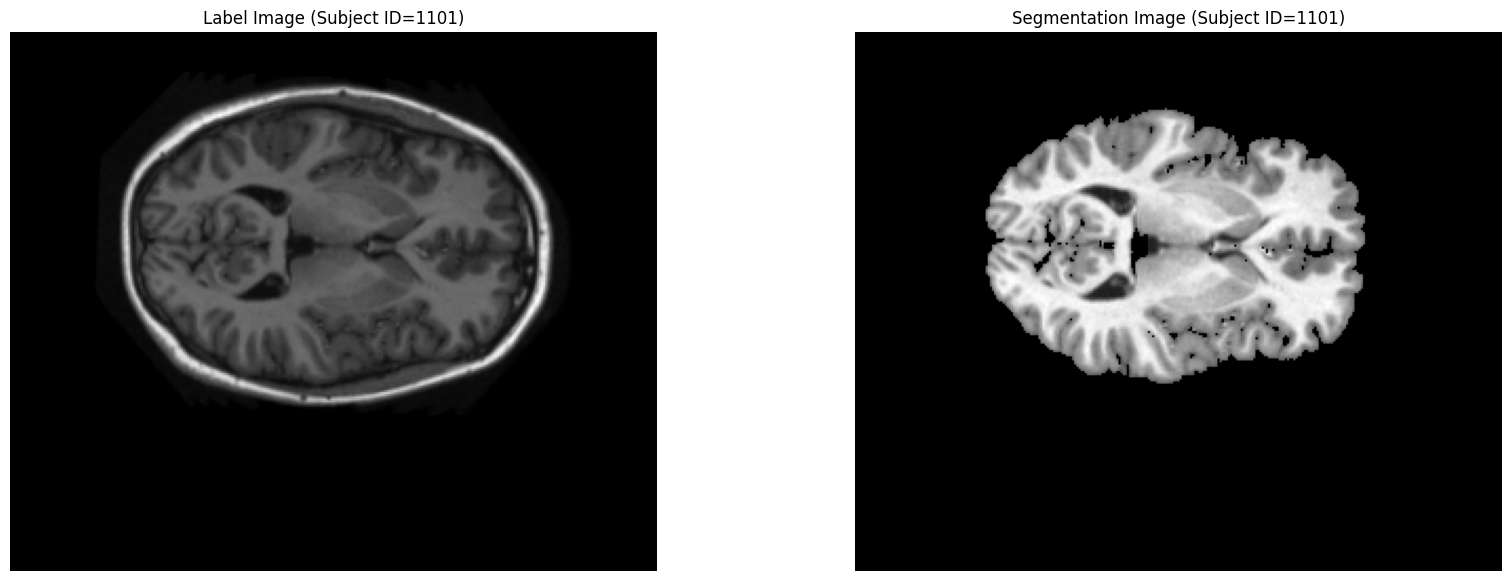

In [7]:
# perform skull stripping
skull_stripped = skull_stripping(test_intensity_example, test_label_example)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_intensity_example, skull_stripped, subject_id, slice=128)

In [8]:
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

In [9]:
segmentation_tissue_model, _ = BM.segment_using_tissue_models(skull_stripped, test_label_example, tissue_map_csv)

{'WM': 0.887852, 'GM': 0.896629, 'CSF': 0.501245}


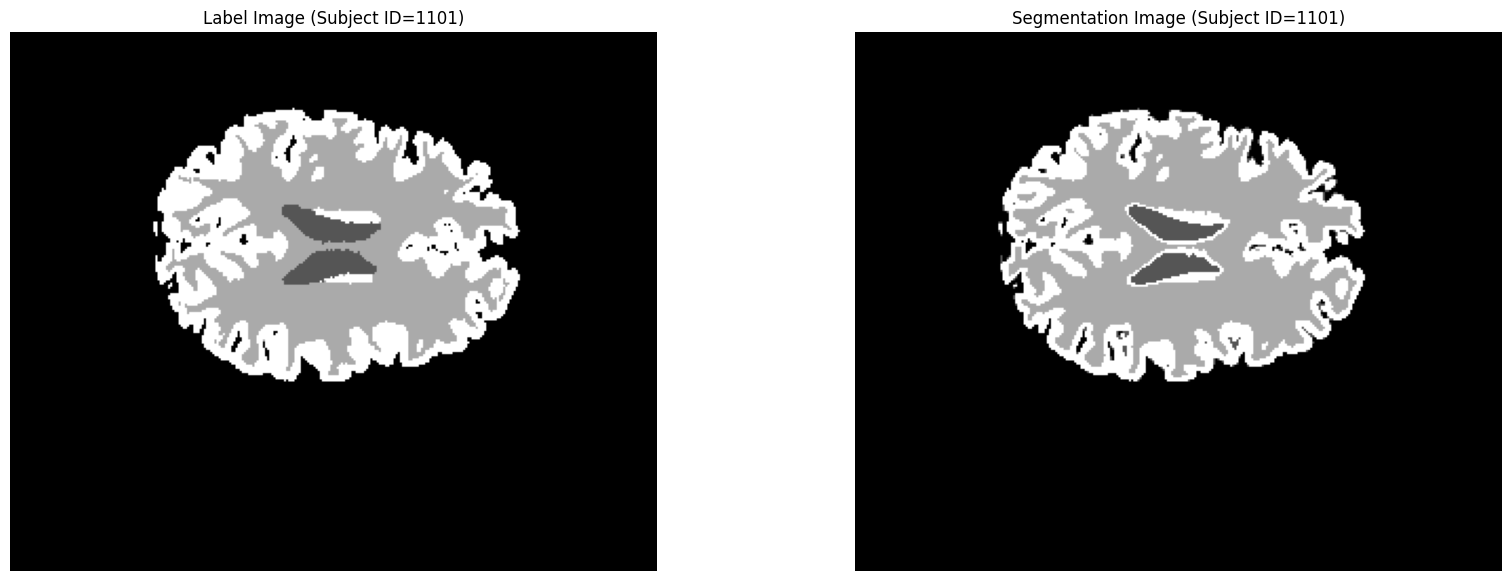

In [10]:
# Evaluate using DICE score
print(
    EVAL.evaluate_dice_volumes(segmentation_tissue_model, test_label_example, labels={'BG':0, 'CSF':1, 'WM':2, 'GM':3}))

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_label_example, segmentation_tissue_model, subject_id, slice=148)

### (1.2) Label propagation: segmentation using just position information

To segment using the atlases, we need to register the test images and perform label propagation using the a reference frame. The reference frame for this task will be the averaged intensity atlas.

In [11]:
# register with float64 data volume
averaged_intensity_atlas_path = 'atlas_outputs/mean_intensity.nii.gz'
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

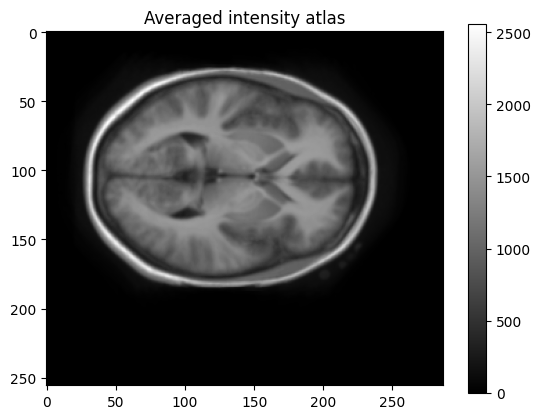

In [12]:
averaged_intensity_atlas, _ = NM.load_nifti(averaged_intensity_atlas_path)

NM.show_nifti(averaged_intensity_atlas, title="Averaged intensity atlas", slice=128)

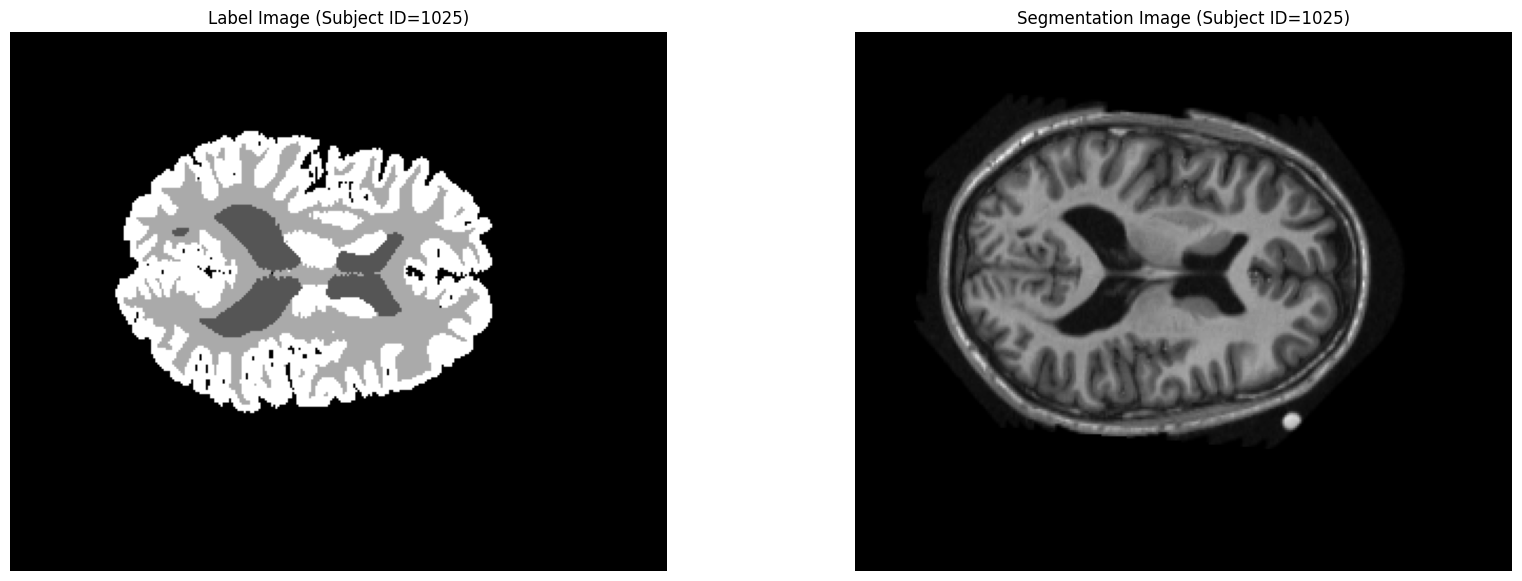

In [13]:
# take a single example to create the function
registered_volume_test_path = 'test-set/testing-images/1025.nii.gz'
registered_label_test_path  = 'test-set/testing-labels/1025_3C.nii.gz'

registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)
registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   

registered_label_test, _ = NM.load_nifti(registered_label_test_path)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1025, slice=148)

In [14]:
# note that the shape matches the registered image, thus we can perform the segmentation!
registered_volume_test.flatten().shape 

(20447232,)

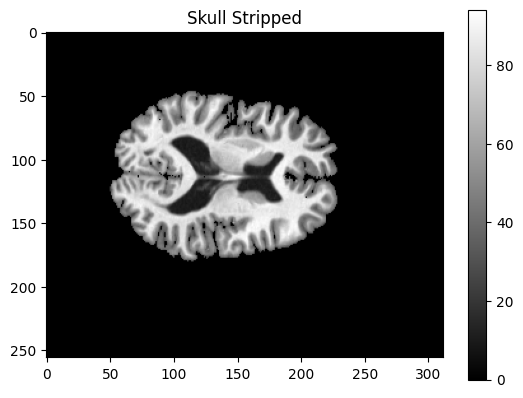

In [15]:
# before we segment the test, we perform skull stripping on it
registered_volume_test_ss = skull_stripping(registered_volume_test, registered_label_test)

NM.show_nifti(registered_volume_test_ss, title="Skull Stripped", slice=148)

{'WM': 0.765053, 'GM': 0.857834, 'CSF': 0.794347}


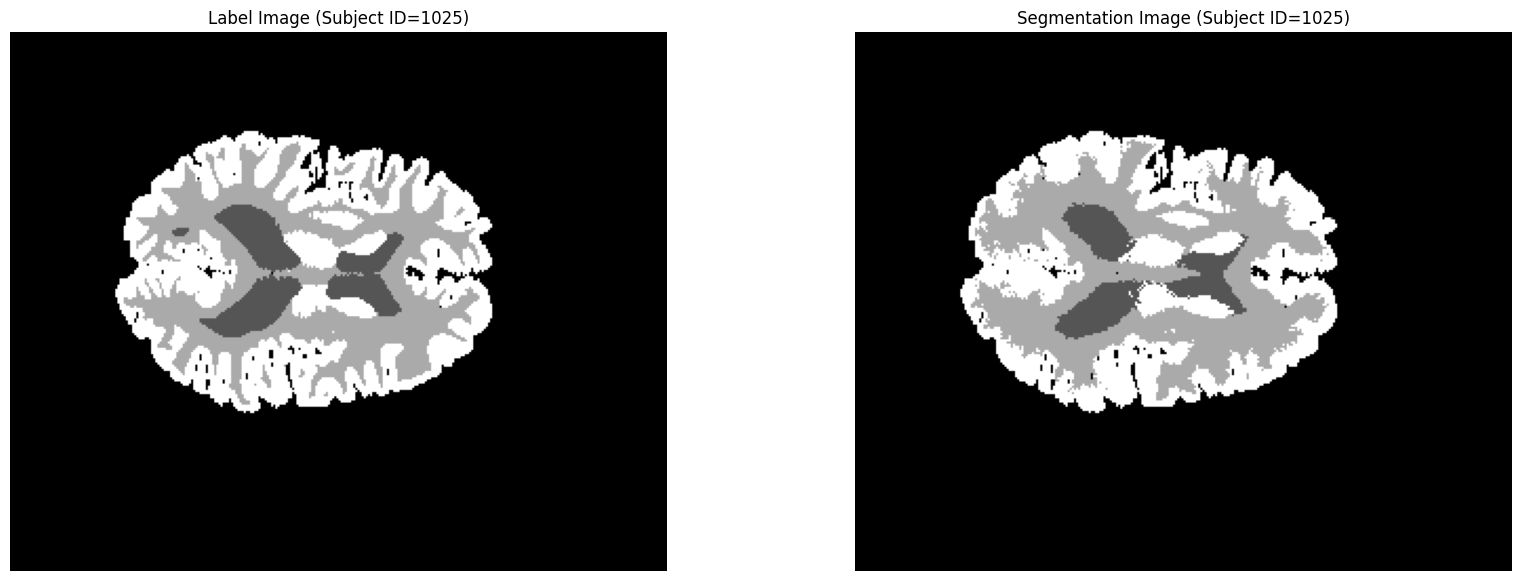

In [16]:
atlas_csf = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_csf/result.nii')[0]
atlas_wm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_wm/result.nii')[0]
atlas_gm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_gm/result.nii')[0]

segmented_image, _ = BM.segment_using_tissue_atlas(registered_volume_test_ss, registered_label_test, atlas_csf, atlas_wm, atlas_gm)

# Evaluate using DICE score
print(
    EVAL.evaluate_dice_volumes(segmented_image, registered_label_test, labels={'BG':0, 'CSF':1, 'WM':2, 'GM':3}))

NM.show_label_seg_nifti(registered_label_test, segmented_image, 1025, slice=148)

### (1.3) Tissue models & label propagation: multiplying both results: segmentation using intensity & position information

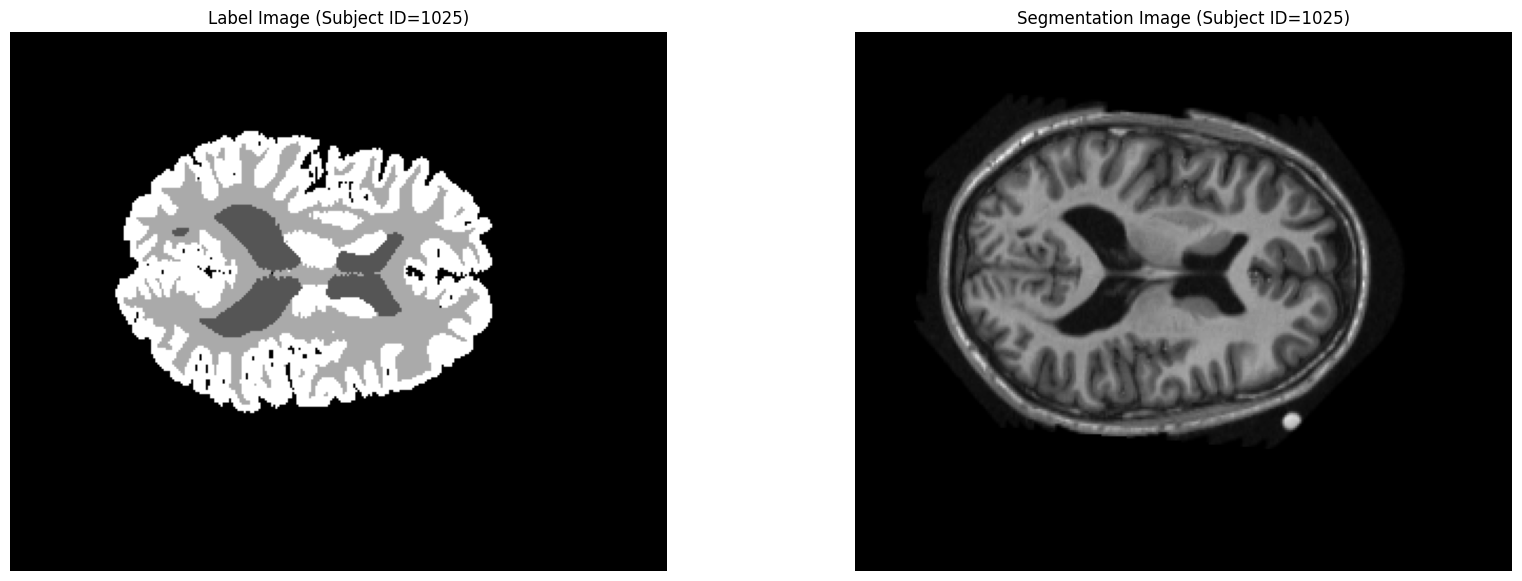

In [17]:
# take a single example to create the function
registered_volume_test_path = 'test-set/testing-images/1025.nii.gz'
registered_label_test_path  = 'test-set/testing-labels/1025_3C.nii.gz'

registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)
registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   

registered_label_test, _ = NM.load_nifti(registered_label_test_path)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1025, slice=148)

In [18]:
# taking into account as well the intensity information
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

{'WM': 0.92479, 'GM': 0.956615, 'CSF': 0.89923}


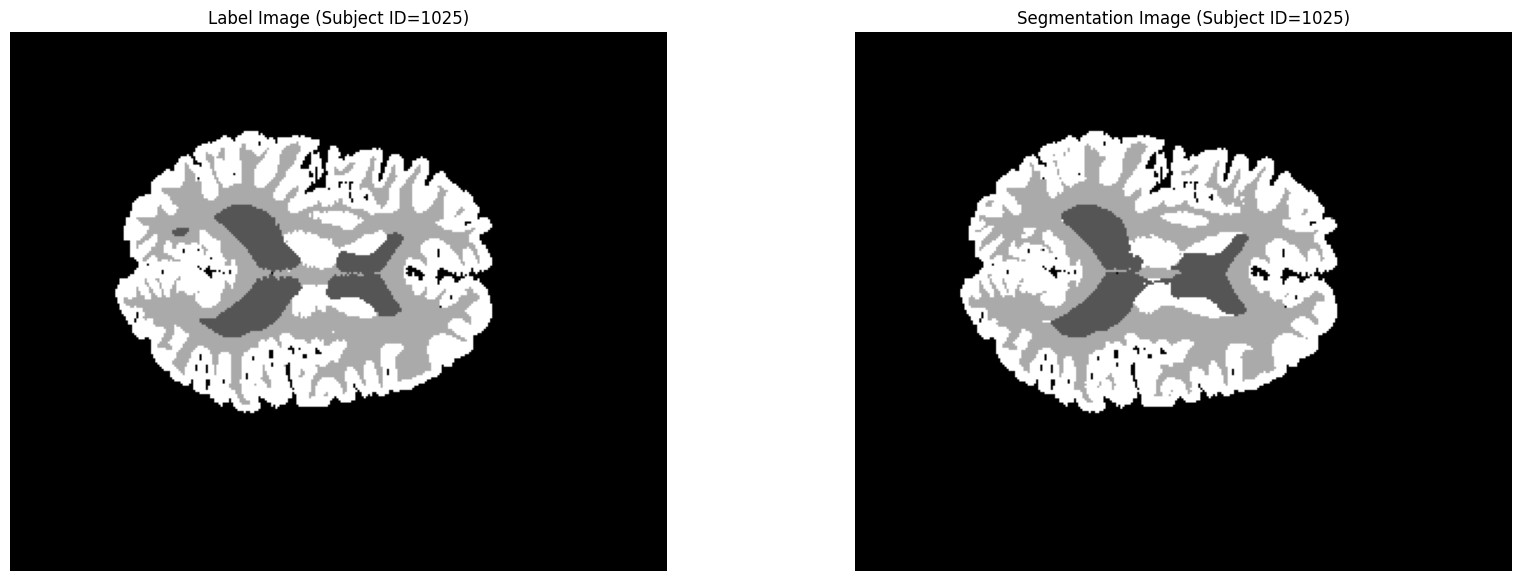

In [19]:
atlas_csf = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_csf/result.nii')[0]
atlas_wm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_wm/result.nii')[0]
atlas_gm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_gm/result.nii')[0]

segmented_image, _ = BM.segment_using_tissue_models_and_atlas(
    registered_volume_test,
    registered_label_test,
    tissue_map_csv,
    atlas_csf, 
    atlas_wm, 
    atlas_gm
)

# Evaluate using DICE score
print(
    EVAL.evaluate_dice_volumes(segmented_image, registered_label_test, labels={'BG':0, 'CSF':1, 'WM':2, 'GM':3}))

NM.show_label_seg_nifti(registered_label_test, segmented_image, 1025, slice=148)
# NM.show_nifti(segmented_image, title="Segmented volume (Atlases + Tissue Map)", slice=137)